# XFeat matching example using torch hub
使用torch hub的匹配示例

涉及的函数：
1. 两张图像稀疏匹配： `图像1匹配点像素坐标<列表>, 图像2匹配点像素坐标<列表> = xfeat.match_xfeat(图像1, 图像2, top_k)`
2. 两张图像半稠密匹配：`图像1匹配点像素坐标<列表>, 图像2匹配点像素坐标<列表> = xfeat.match_xfeat_star(图像1, 图像2, top_k)`

## Initialize XFeat

In [60]:
import numpy as np
import imageio as imio      # 读写图像数据的库
import os
import torch
import tqdm                 # 显示进度条
import cv2
import matplotlib.pyplot as plt

# 从 "verlab/accelerated_features" github 仓库中加载名为 XFeat 的模型，并指定参数 pretrained = True 和 top_k = 4096
xfeat = torch.hub.load('verlab/accelerated_features', 'XFeat', pretrained = True, top_k = 4096, trust_repo=True)

# 从指定的 URL 中加载两张图片，并将颜色通道从 BGR 转换为 RGB 
im1 = np.copy(imio.v2.imread('https://raw.githubusercontent.com/verlab/accelerated_features/main/assets/ref.png')[..., ::-1])
im2 = np.copy(imio.v2.imread('https://raw.githubusercontent.com/verlab/accelerated_features/main/assets/tgt.png')[..., ::-1])

Using cache found in /home/speike/.cache/torch/hub/verlab_accelerated_features_main


## Simple function that fits an homography in a set of matches and draw the homography transform
用于在一组匹配点上拟合单应变换，并绘制单应变换的简单函数

In [61]:
import cv2
import numpy as np

def warp_corners_and_draw_matches(ref_points, dst_points, img1, img2):
    # 使用OpenCV的findHomography函数计算单应性矩阵H
    H, mask = cv2.findHomography(ref_points, dst_points, cv2.USAC_MAGSAC, 3.5, maxIters=1_000, confidence=0.999)
    # 将mask展平，mask保留了计算单应性矩阵H时使用的内点
    mask = mask.flatten()

    # 获取第一张图片的宽度和高度
    h, w = img1.shape[:2]
    # 定义第一张图片的四个顶点的坐标
    corners_img1 = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32).reshape(-1, 1, 2)

    # 使用单应性矩阵H将第一张图片的四个顶点坐标映射到第二张图片中
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # 在第二张图片上绘制四个顶点及其连接成的矩形
    img2_with_corners = img2.copy()
    for i in range(len(warped_corners)):
        start_point = tuple(warped_corners[i-1][0].astype(int))
        end_point = tuple(warped_corners[i][0].astype(int))
        cv2.line(img2_with_corners, start_point, end_point, (0, 255, 0), 4)  # Using solid green for corners

    # 准备图像一和图像二的关键点，x,y坐标和大小(默认为5)
    keypoints1 = [cv2.KeyPoint(p[0], p[1], 5) for p in ref_points]
    keypoints2 = [cv2.KeyPoint(p[0], p[1], 5) for p in dst_points]
    # 如果mask中的值为True，即为计算单应性矩阵H时使用的内点，将其添加到matches中
    matches = [cv2.DMatch(i,i,0) for i in range(len(mask)) if mask[i]]
    print(f"inliers: {len(matches)}")

    # 使用drawMatches函数绘制匹配的关键点
    img_matches = cv2.drawMatches(img1, keypoints1, img2_with_corners, keypoints2, matches, None,
                                  matchColor=(0, 255, 0), flags=2)

    return img_matches


## Matching example - sparse setting
匹配示例 - 稀疏设置

**匹配结果也会有外点，warp_corners_and_draw_matches函数中进行了剔除外点，mkpts_0和mkpts_1中储存的是两张图像中对应点的坐标**
可以尝试把warp_corners_and_draw_matches函数中 if mask[i] 注释了，可以看出全部的匹配结果外点还是挺多的

Found 832 matches
inliers: 184


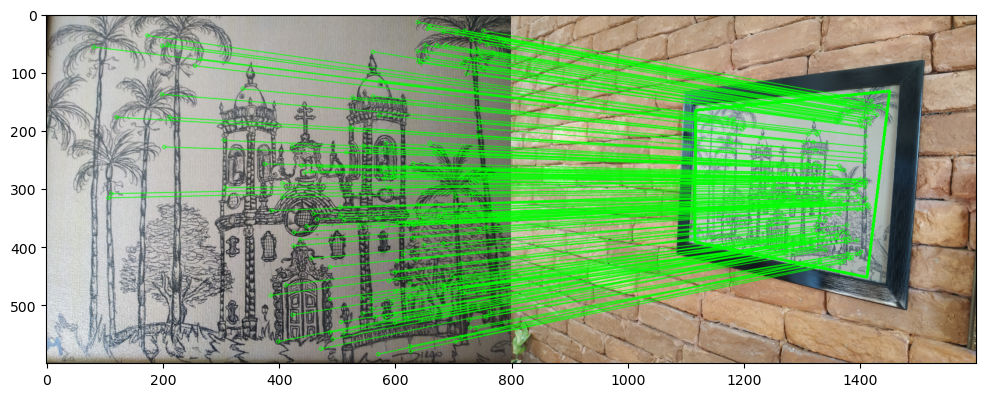

(<matplotlib.image.AxesImage at 0x7f9f84548c10>, None)

In [62]:
#Use out-of-the-box function for extraction + MNN matching  使用现成的函数进行特征提取和MNN(最小化最近邻)匹配
# 输入两张图片，返回两张图片对应的特征点
mkpts_0, mkpts_1 = xfeat.match_xfeat(im1, im2, top_k = 4096)
print(f"Found {len(mkpts_0)} matches")

canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1]), plt.show()

## Matching example - Semi-dense setting
匹配示例 - 半稠密设置

半稠密匹配的成功率高，论文中的图片也说明了

Found 1099 matches
inliers: 866


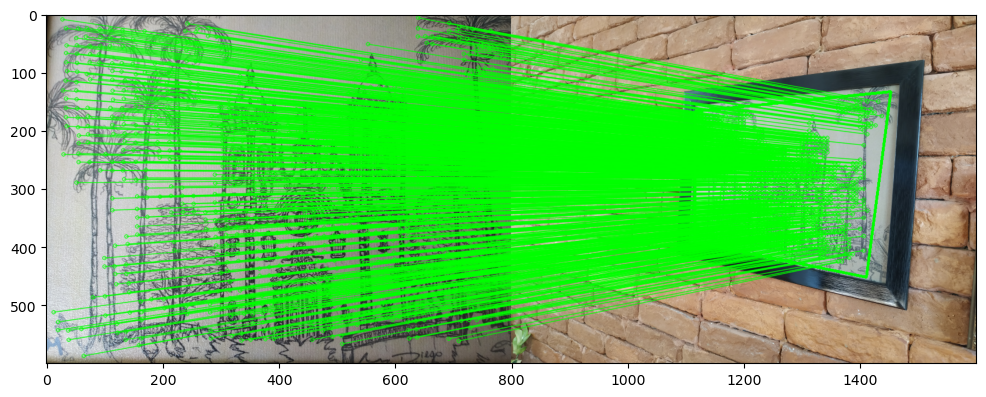

(<matplotlib.image.AxesImage at 0x7f9f582e6c40>, None)

In [63]:
# Use out-of-the-box function for extraction + coarse-to-fine matching  使用现成的函数进行特征提取和粗到细的匹配
mkpts_0, mkpts_1 = xfeat.match_xfeat_star(im1, im2, top_k = 8000)
print(f"Found {len(mkpts_0)} matches")

canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1]), plt.show()